In [3]:
!python -m pip uninstall -y torch torchvision torchaudio
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!python -m pip install mamba-ssm
#!python --version
#!pip install --upgrade pip
#!pip uninstall keras tensorflow
#!pip install -r ../requirements.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.3-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.3 kB)
Using cached ninja-1.11.1.3-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (422 kB)
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.4-cp311-cp311-linux_x86_64.whl size=323672993 sha256=8a0be01153fa30727a9e69024fbe061eb92c7ba4416d2049c5fc3107ed91d852
  Stored in directory: /root/.cache/pip/wheels/2a/5e/64/cfcb5dfe4f854944456e031c34953dc872af1ad7c206145d4a
Successfully built mamba-ssm


In [ ]:
# Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import json
import gc

from data_loader import load_cifar10, get_class_names
from ssm import FastImageMamba, ModelArgs  # For MAMBA model
from model import CNN  # For CNN model


ModuleNotFoundError: No module named 'data_loader'

In [ ]:
class ImprovedAttackModel(nn.Module):
    def __init__(self, input_features=256):  # Increased feature dimensionality
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 2)  # Binary classification: member vs non-member
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
def prepare_improved_attack_data(target_model, train_loader, test_loader, device):
    """Prepare data for training the attack model with enhanced features and balanced classes."""
    member_inputs = []
    non_member_inputs = []

    print("  Collecting member data from training set...")
    target_model.eval()
    with torch.no_grad():
        # Process training data (members)
        for i, (data, _) in enumerate(train_loader):
            data = data.to(device)
            logits, probs = target_model(data)

            # Calculate additional features
            confidence_margins = probs.max(1)[0] - probs.sort(1)[0][:,-2]
            pred_entropy = -(probs * torch.log(probs + 1e-10)).sum(1)

            features = torch.cat([
                logits,
                probs,
                confidence_margins.unsqueeze(1),
                pred_entropy.unsqueeze(1)
            ], dim=1)

            member_inputs.append(features.cpu())

        print("  Collecting non-member data from test set...")
        # Process test data (non-members)
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            logits, probs = target_model(data)

            confidence_margins = probs.max(1)[0] - probs.sort(1)[0][:,-2]
            pred_entropy = -(probs * torch.log(probs + 1e-10)).sum(1)

            features = torch.cat([
                logits,
                probs,
                confidence_margins.unsqueeze(1),
                pred_entropy.unsqueeze(1)
            ], dim=1)

            non_member_inputs.append(features.cpu())

    # Concatenate all samples
    print("  Concatenating collected data...")
    member_data = torch.cat(member_inputs)
    non_member_data = torch.cat(non_member_inputs)
    print(f"  Collected {member_data.size(0)} member samples and {non_member_data.size(0)} non-member samples")

    # Balance the dataset by using the same number of members and non-members
    min_samples = min(member_data.size(0), non_member_data.size(0))
    print(f"  Balancing dataset to {min_samples} samples per class")

    # Randomly select samples if needed to ensure balance
    member_indices = torch.randperm(member_data.size(0))[:min_samples]
    non_member_indices = torch.randperm(non_member_data.size(0))[:min_samples]

    balanced_member_data = member_data[member_indices]
    balanced_non_member_data = non_member_data[non_member_indices]

    # Create balanced X and y
    X = torch.cat([balanced_member_data, balanced_non_member_data])
    y = torch.cat([
        torch.ones(min_samples, dtype=torch.long),
        torch.zeros(min_samples, dtype=torch.long)
    ])

    # Shuffle the combined data
    print("  Shuffling the combined data...")
    shuffle_indices = torch.randperm(X.size(0))
    X = X[shuffle_indices]
    y = y[shuffle_indices]

    print(f"  Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
    return X, y

In [ ]:
def train_attack_model(attack_model, train_data, train_labels, val_data, val_labels,
                      device, epochs=50, epoch_num=None, model_type=None):  # Changed from 10 to 50
    """Train the attack model with detailed logging."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(attack_model.parameters(), lr=0.001)

    if epoch_num is not None and model_type is not None:
        print(f"Starting attack model training on {model_type} checkpoint (epoch {epoch_num})")

    print(f"Attack training data shape: {train_data.shape}, labels shape: {train_labels.shape}")
    print(f"Attack validation data shape: {val_data.shape}, labels shape: {val_labels.shape}")

    best_val_acc = 0
    best_epoch = 0
    train_accs = []
    val_accs = []
    patience = 10  # Number of epochs to wait for improvement
    min_improvement = 0.001  # Minimum improvement threshold (0.1%)

    for epoch in range(epochs):
        # Training
        attack_model.train()
        optimizer.zero_grad()

        outputs = attack_model(train_data.to(device))
        loss = criterion(outputs, train_labels.to(device))
        loss.backward()
        optimizer.step()

        # Evaluation
        attack_model.eval()
        with torch.no_grad():
            # Training accuracy
            _, predicted = outputs.max(1)
            train_acc = predicted.eq(train_labels.to(device)).float().mean().item()

            # Validation accuracy
            val_outputs = attack_model(val_data.to(device))
            _, val_predicted = val_outputs.max(1)
            val_acc = val_predicted.eq(val_labels.to(device)).float().mean().item()

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print progress every few epochs
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"  Attack epoch {epoch}/{epochs-1}: Loss={loss.item():.4f}, Train acc={train_acc:.4f}, Val acc={val_acc:.4f}")

        # Check if this is the best model
        if val_acc > best_val_acc + min_improvement:
            best_val_acc = val_acc
            best_epoch = epoch
            print(f"  New best validation accuracy: {best_val_acc:.4f}")

        # Early stopping check after sufficient training
        if epoch >= 20 and epoch - best_epoch > patience:
            print(f"  Early stopping at epoch {epoch} as no improvement for {patience} epochs")
            break

    print(f"Attack model training completed. Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
    return train_accs, val_accs, best_val_acc

In [ ]:
def evaluate_checkpoint(model_name, checkpoint_path, model, train_loader, test_loader, device):
    """Evaluate a model checkpoint using the improved attack model with detailed logging."""
    print(f"\nAnalyzing {model_name} checkpoint: {checkpoint_path}")
    try:
        # Get checkpoint directory and epoch
        print("  Getting checkpoint info...")
        checkpoint_dir = os.path.dirname(checkpoint_path)
        epoch = int(os.path.basename(checkpoint_path).split('_')[-1].split('.')[0])

        # Load checkpoint - Disable weights-only for trusted checkpoints
        print(f"  Loading checkpoint from {checkpoint_dir}...")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        print("  Checkpoint loaded successfully")

        print("  Loading model state...")
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print("  Model state loaded successfully")

        # Continue with the rest of your function...

        # Prepare attack data with enhanced features
        print("  Preparing attack data with enhanced features...")
        print("  Processing training data (members)...")
        X, y = prepare_improved_attack_data(model, train_loader, test_loader, device)
        print(f"  Attack data prepared: X shape={X.shape}, y shape={y.shape}")

        # Split data with stratification
        print("  Splitting data into train/validation sets...")
        indices = torch.randperm(len(X))
        train_size = int(0.8 * len(X))
        train_idx = indices[:train_size]
        val_idx = indices[train_size:]

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        print(f"  Data split complete: {len(X_train)} training samples, {len(X_val)} validation samples")

        # Check balance in both training and validation sets
        train_members = (y_train == 1).sum().item()
        train_non_members = (y_train == 0).sum().item()
        print(f"  Training set balance: {train_members}/{len(y_train)} members ({train_members/len(y_train)*100:.1f}%)")

        val_members = (y_val == 1).sum().item()
        val_non_members = (y_val == 0).sum().item()
        print(f"  Validation set balance: {val_members}/{len(y_val)} members ({val_members/len(y_val)*100:.1f}%)")

        # Train attack model
        print("  Creating attack model...")
        attack_model = ImprovedAttackModel(input_features=X.shape[1]).to(device)
        print(f"  Attack model created with {X.shape[1]} input features")

        print("  Starting attack model training...")
        train_accs, val_accs, best_acc = train_attack_model(
            attack_model, X_train, y_train, X_val, y_val, device,
            epoch_num=epoch, model_type=model_name
        )
        print("  Attack model training complete")

        return {
            'epoch': epoch,
            'attack_accuracy': best_acc * 100,
            'train_history': train_accs,
            'val_history': val_accs
        }
    except Exception as e:
        print(f"  ERROR processing checkpoint: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

In [ ]:
def save_results_to_json(results, filename='attack_results/analysis_results.json'):
    """Save analysis results to JSON file."""
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # Convert any numpy arrays or torch tensors to lists
    json_results = {
        model_type: {
            'accuracies': [float(acc) for acc in data['accuracies']],
            'epochs': [int(epoch) for epoch in data['epochs']],
            'results': data['results']
        }
        for model_type, data in results.items()
    }

    with open(filename, 'w') as f:
        json.dump(json_results, f, indent=4)
    print(f"Results saved to {filename}")

def load_results_from_json(filename='attack_results/analysis_results.json'):
    """Load analysis results from JSON file."""
    with open(filename, 'r') as f:
        return json.load(f)


# New function to plot from saved results
def plot_from_saved_results(filename='attack_results/analysis_results.json'):
    """Load saved results and create plots."""
    results = load_results_from_json(filename)
    plot_results(results)

In [ ]:
def analyze_models():
    """Main analysis function with results saving."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    train_loader, test_loader, _, _, _, _ = load_cifar10(batch_size=64, seed=42)

    model_args = ModelArgs(
    d_model=64,
    n_layer=4,
    vocab_size=10,
    d_state=16,
    expand=2,
    dt_rank=16,
    d_conv=4,
    seq_len=1024  # Changed to handle full image sequences
    )
    mamba_model = FastImageMamba(model_args, num_classes=10).to(device)
    cnn_model = CNN().to(device)

    # Checkpoint directories
    mamba_checkpoint_dir = '/content/drive/MyDrive/mamba_checkpoints/'
    cnn_checkpoint_dir = '/content/drive/MyDrive/cnn_checkpoints/'

    results = {
        'mamba': {
            'accuracies': [],  # Store all accuracies
            'epochs': [],      # Store corresponding epochs
            'results': []      # Store the original result dictionaries
        },
        'cnn': {
            'accuracies': [],
            'epochs': [],
            'results': []
        }
    }

    # Analyze MAMBA checkpoints
    print("\nAnalyzing MAMBA checkpoints...")
    for epoch in range(100, 601, 100):
        checkpoint_path = os.path.join(mamba_checkpoint_dir, f'mamba_epoch_{epoch}.pt')
        result = evaluate_checkpoint(
            'MAMBA',
            checkpoint_path,
            mamba_model,
            train_loader,
            test_loader,
            device
        )
        if result:
            results['mamba']['accuracies'].append(result['attack_accuracy'])
            results['mamba']['epochs'].append(result['epoch'])
            results['mamba']['results'].append(result)

    # Clear memory, manage and release GPU memory after analyzing the MAMBA checkpoints. Now we can do CNN
    del mamba_model
    torch.cuda.empty_cache()
    gc.collect()

    # Analyze CNN checkpoints
    print("\nAnalyzing CNN checkpoints...")
    for epoch in range(100, 601, 100):
        checkpoint_path = os.path.join(cnn_checkpoint_dir, f'cnn_epoch_{epoch}.pt')
        result = evaluate_checkpoint(
            'CNN',
            checkpoint_path,
            cnn_model,
            train_loader,
            test_loader,
            device
        )
        if result:
            results['cnn']['accuracies'].append(result['attack_accuracy'])
            results['cnn']['epochs'].append(result['epoch'])
            results['cnn']['results'].append(result)
    save_results_to_json(results)
    return results

In [21]:
def plot_results(results):
    """Plot comparison of attack success rates."""
    plt.figure(figsize=(12, 6))

    # Sort results by epoch
    mamba_results = sorted(results['mamba'], key=lambda x: x['epoch'])
    cnn_results = sorted(results['cnn'], key=lambda x: x['epoch'])

    # Extract data
    mamba_epochs = [r['epoch'] for r in mamba_results]
    mamba_acc = [r['attack_accuracy'] for r in mamba_results]

    cnn_epochs = [r['epoch'] for r in cnn_results]
    cnn_acc = [r['attack_accuracy'] for r in cnn_results]

    # Plot
    plt.plot(mamba_epochs, mamba_acc, 'b-o', label='MAMBA')
    plt.plot(cnn_epochs, cnn_acc, 'r-o', label='CNN')
    plt.axhline(y=50, color='gray', linestyle='--', label='Random Guess')

    plt.title('Membership Inference Attack Success Rate vs Training Progress')
    plt.xlabel('Training Epochs')
    plt.ylabel('Attack Success Rate (%)')
    plt.legend()
    plt.grid(True)

    # Save plot
    os.makedirs('attack_results', exist_ok=True)
    plt.savefig('attack_results/attack_comparison.png')
    plt.show()

    # Print summary
    print("\nFinal Attack Results:")
    print("=" * 50)
    print(f"MAMBA final vulnerability: {mamba_acc[-1]:.2f}%")
    print(f"CNN final vulnerability: {cnn_acc[-1]:.2f}%")

    conclusion = "MAMBA" if mamba_acc[-1] > cnn_acc[-1] else "CNN"
    print(f"\nConclusion: {conclusion} appears more vulnerable to membership inference attacks")

In [22]:
# Execute the analysis
from check_and_measure import load_last_checkpoint
results = analyze_models()
plot_results(results)

Using device: cuda

Analyzing MAMBA checkpoints...

Analyzing MAMBA checkpoint: /content/drive/MyDrive/mamba_checkpoints/mamba_epoch_100.pt
  Getting checkpoint info...
  Loading checkpoint from /content/drive/MyDrive/mamba_checkpoints...
  Checkpoint loaded successfully
  Loading model state...
  Model state loaded successfully
  Preparing attack data with enhanced features...
  Processing training data (members)...
  Concatenating collected data...
  Collected 50000 member samples and 10000 non-member samples
  Balancing dataset to 10000 samples per class
  Shuffling the combined data...
  Final dataset: 20000 samples, 22 features
  Attack data prepared: X shape=torch.Size([20000, 22]), y shape=torch.Size([20000])
  Splitting data into train/validation sets...
  Data split complete: 16000 training samples, 4000 validation samples
  Training set balance: 7991/16000 members (49.9%)
  Validation set balance: 2009/4000 members (50.2%)
  Creating attack model...
  Attack model created wit

TypeError: string indices must be integers, not 'str'

<Figure size 1200x600 with 0 Axes>

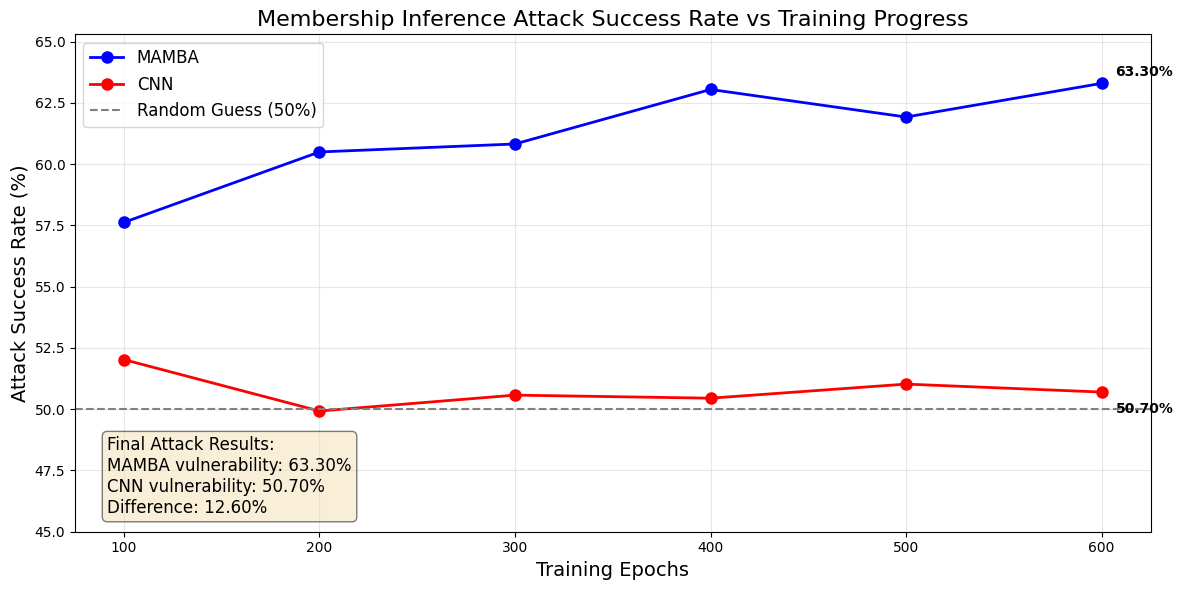


Final Attack Results:
MAMBA final vulnerability: 63.30%
CNN final vulnerability: 50.70%
Difference: 12.60%

Conclusion: MAMBA appears more vulnerable to membership inference attacks


In [23]:
import matplotlib.pyplot as plt
import json
import numpy as np

def load_results_from_json(filename='attack_results/analysis_results.json'):
    """Load analysis results from JSON file."""
    with open(filename, 'r') as f:
        return json.load(f)

def plot_membership_inference_results(results):
    """Plot comparison of membership inference attack success rates."""
    plt.figure(figsize=(12, 6))

    # Extract data for plotting
    mamba_epochs = results['mamba']['epochs']
    mamba_acc = results['mamba']['accuracies']
    cnn_epochs = results['cnn']['epochs']
    cnn_acc = results['cnn']['accuracies']

    # Plot
    plt.plot(mamba_epochs, mamba_acc, 'b-o', linewidth=2, markersize=8, label='MAMBA')
    plt.plot(cnn_epochs, cnn_acc, 'r-o', linewidth=2, markersize=8, label='CNN')
    plt.axhline(y=50, color='gray', linestyle='--', label='Random Guess (50%)')

    # Add annotations for the final points
    plt.annotate(f"{mamba_acc[-1]:.2f}%",
                xy=(mamba_epochs[-1], mamba_acc[-1]),
                xytext=(10, 5),
                textcoords='offset points',
                fontsize=10,
                fontweight='bold')

    plt.annotate(f"{cnn_acc[-1]:.2f}%",
                xy=(cnn_epochs[-1], cnn_acc[-1]),
                xytext=(10, -15),
                textcoords='offset points',
                fontsize=10,
                fontweight='bold')

    # Customize the plot
    plt.title('Membership Inference Attack Success Rate vs Training Progress', fontsize=16)
    plt.xlabel('Training Epochs', fontsize=14)
    plt.ylabel('Attack Success Rate (%)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    # Set y-axis limits with some padding
    max_acc = max(max(mamba_acc), max(cnn_acc))
    min_acc = min(min(mamba_acc), min(cnn_acc))
    plt.ylim(min(45, min_acc - 2), max_acc + 2)

    # Set x-axis ticks to match epochs
    plt.xticks(mamba_epochs)

    # Add a box with summary statistics
    textstr = '\n'.join((
        'Final Attack Results:',
        f'MAMBA vulnerability: {mamba_acc[-1]:.2f}%',
        f'CNN vulnerability: {cnn_acc[-1]:.2f}%',
        f'Difference: {abs(mamba_acc[-1] - cnn_acc[-1]):.2f}%'
    ))

    # Add a text box for the summary
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.03, 0.03, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

    # Save the plot
    plt.tight_layout()
    # Save the plot to the attack_results directory
    import os
    os.makedirs('attack_results', exist_ok=True)
    plt.savefig('attack_results/membership_inference_attack_comparison.png', dpi=300)

    # Display the plot
    plt.show()

    # Print summary
    print("\nFinal Attack Results:")
    print("=" * 50)
    print(f"MAMBA final vulnerability: {mamba_acc[-1]:.2f}%")
    print(f"CNN final vulnerability: {cnn_acc[-1]:.2f}%")
    print(f"Difference: {abs(mamba_acc[-1] - cnn_acc[-1]):.2f}%")

    conclusion = "MAMBA" if mamba_acc[-1] > cnn_acc[-1] else "CNN"
    print(f"\nConclusion: {conclusion} appears more vulnerable to membership inference attacks")

if __name__ == "__main__":
    # Load the results and create the plot
    try:
        results = load_results_from_json('attack_results/analysis_results.json')
        plot_membership_inference_results(results)
    except FileNotFoundError:
        print("File not found at attack_results/analysis_results.json")
        print("Trying with the provided paste.txt file instead...")
        # Use the paste.txt file if the json is not found
        import json
        with open('paste.txt', 'r') as f:
            results = json.load(f)
        plot_membership_inference_results(results)

In [1]:
def analyze_mamba_model():
    """Analyze only MAMBA model checkpoints and save results."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    train_loader, test_loader, _, _, _, _ = load_cifar10(batch_size=64, seed=42)

    # Initialize MAMBA model
    model_args = ModelArgs(
        d_model=64,
        n_layer=4,
        vocab_size=10,
        d_state=16,
        expand=2,
        dt_rank=16,
        d_conv=4,
        seq_len=1024
    )
    mamba_model = FastImageMamba(model_args, num_classes=10).to(device)

    # Checkpoint directory
    mamba_checkpoint_dir = '/content/drive/MyDrive/mamba_checkpoints/'

    mamba_results = {
        'accuracies': [],  # Store all accuracies
        'epochs': [],      # Store corresponding epochs
        'results': []      # Store the original result dictionaries
    }

    # Analyze MAMBA checkpoints
    print("\nAnalyzing MAMBA checkpoints...")
    for epoch in range(100, 601, 100):
        checkpoint_path = os.path.join(mamba_checkpoint_dir, f'mamba_epoch_{epoch}.pt')
        result = evaluate_checkpoint(
            'MAMBA',
            checkpoint_path,
            mamba_model,
            train_loader,
            test_loader,
            device
        )
        if result:
            mamba_results['accuracies'].append(result['attack_accuracy'])
            mamba_results['epochs'].append(result['epoch'])
            mamba_results['results'].append(result)

    # Optionally save MAMBA results to a separate file
    save_results_to_json({'mamba': mamba_results}, 'attack_results/mamba_analysis_results.json')

    # Clear memory
    del mamba_model
    torch.cuda.empty_cache()
    gc.collect()

    return mamba_results


def analyze_cnn_model():
    """Analyze only CNN model checkpoints and save results."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    train_loader, test_loader, _, _, _, _ = load_cifar10(batch_size=64, seed=42)

    # Initialize CNN model
    cnn_model = CNN().to(device)

    # Checkpoint directory
    cnn_checkpoint_dir = '/content/drive/MyDrive/cnn_checkpoints/'

    cnn_results = {
        'accuracies': [],  # Store all accuracies
        'epochs': [],      # Store corresponding epochs
        'results': []      # Store the original result dictionaries
    }

    # Analyze CNN checkpoints
    print("\nAnalyzing CNN checkpoints...")
    for epoch in range(100, 601, 100):
        checkpoint_path = os.path.join(cnn_checkpoint_dir, f'cnn_epoch_{epoch}.pt')
        result = evaluate_checkpoint(
            'CNN',
            checkpoint_path,
            cnn_model,
            train_loader,
            test_loader,
            device
        )
        if result:
            cnn_results['accuracies'].append(result['attack_accuracy'])
            cnn_results['epochs'].append(result['epoch'])
            cnn_results['results'].append(result)

    # Optionally save CNN results to a separate file
    save_results_to_json({'cnn': cnn_results}, 'attack_results/cnn_analysis_results.json')

    # Clear memory
    del cnn_model
    torch.cuda.empty_cache()
    gc.collect()

    return cnn_results


def combine_and_plot_results(mamba_results, cnn_results):
    """Combine results from both models and create comparative plots.

    Args:
        mamba_results: Results dictionary from analyze_mamba_model()
        cnn_results: Results dictionary from analyze_cnn_model()
    """
    # Combine results
    combined_results = {
        'mamba': mamba_results,
        'cnn': cnn_results
    }

    # Optionally save combined results
    save_results_to_json(combined_results, 'attack_results/combined_analysis_results.json')

    # Plot combined results
    plot_results(combined_results)


# Modified plot_results function that works with the new data structure
def plot_results(results):
    """Plot comparison of attack success rates."""
    plt.figure(figsize=(12, 6))

    # Check if results data is in the expected format
    mamba_epochs = results['mamba']['epochs']
    mamba_acc = results['mamba']['accuracies']
    cnn_epochs = results['cnn']['epochs']
    cnn_acc = results['cnn']['accuracies']

    # Plot
    plt.plot(mamba_epochs, mamba_acc, 'b-o', label='MAMBA')
    plt.plot(cnn_epochs, cnn_acc, 'r-o', label='CNN')
    plt.axhline(y=50, color='gray', linestyle='--', label='Random Guess')

    plt.title('Membership Inference Attack Success Rate vs Training Progress')
    plt.xlabel('Training Epochs')
    plt.ylabel('Attack Success Rate (%)')
    plt.legend()
    plt.grid(True)

    # Save plot
    os.makedirs('attack_results', exist_ok=True)
    plt.savefig('attack_results/attack_comparison.png')
    plt.show()

    # Print summary
    print("\nFinal Attack Results:")
    print("=" * 50)
    print(f"MAMBA final vulnerability: {mamba_acc[-1]:.2f}%")
    print(f"CNN final vulnerability: {cnn_acc[-1]:.2f}%")

    conclusion = "MAMBA" if mamba_acc[-1] > cnn_acc[-1] else "CNN"
    print(f"\nConclusion: {conclusion} appears more vulnerable to membership inference attacks")




In [ ]:
mamba_results = analyze_mamba_model()

In [2]:
cnn_results = analyze_cnn_model()

NameError: name 'torch' is not defined

In [ ]:
combine_and_plot_results(mamba_results, cnn_results)